**RQ3**
---

**How do individual and country differences (German, Japanese, Jordanian) influence the experience and physiological responses to awe-inducing stimuli?**

- H3.1: Country of origin will influence the self-reported experience of awe and physiological manifestation, with variations reflecting cultural values and norms related to different types of awe-inspiring stimuli.
    - ToDo: Analyse differences in AWE-S scores (1) and physiological reaction (SCR, SCL, resp_rate) (2) based on country of origin
- H3.2: Personality traits will influence the self-reported experience of awe and physiological manifestation, specifically with the trait Openness to Experience being positively correlated with high self-reported awe.
    - ToDo: Analyse differences in AWE-S scores (1) and physiological reaction (SCR, SCL, resp_rate) (2) based on TIPI Openness to Experience score

Get from data: 
- AWE-S scores
- GSR measures (SCR, SCL)
- Respiration measure (resp_rate)
- country of origin
- TIPI Openness to Experience scores

**Boferroni correction for multiple comparisons** \
For Hypothesis 2 we have \
H3.1: 12 + 5\
H3.2: 4 \
= 21

In [1]:
bonferroniCorrection = 21

**Import statements**

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ks_2samp, levene, f_oneway, kruskal, spearmanr, pearsonr, linregress
import statsmodels.stats.multitest as smm
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp
import os
import re

**Load data**

In [3]:
filepath_questionnaire = "processed data/combined_questionnaire_dataLikert.csv"
filepath_physio = "processed data/RQ3_combined_AWE_TIPI_physio_data.csv"
filepath_combined_physio = "processed data/Step3_RQ2_output_combined_awe_physiological_data.csv"

def load_data(filepath):
    return pd.read_csv(filepath)

def parse_physio_data(filepath):
    df = pd.read_csv(filepath)
    df['Culture'] = df['file'].apply(lambda x: 'Germany' if 'Germany' in x else ('Jordan' if 'Jordan' in x else 'Japan'))
    return df

data_questionnaire = load_data(filepath_questionnaire)
data_physio = parse_physio_data(filepath_physio)
data_combined = load_data(filepath_combined_physio)

conditions = [
    "AbstractAwe", "Borealis", "Church", "Forest", "Mountain",
    "Neutral1", "Neutral3", "Space", "Underwater", "Waterfall"
]

groups = {
    'Human_Made': ['Church', 'Neutral3'],
    'Natural': ['Underwater', 'Waterfall', 'Space', 'Mountain', 'Forest', 'Borealis'],
    'Abstract': ['AbstractAwe', 'Neutral1']
}

awe_groups = {
    'High_Awe': ['Space'],
    'Medium_High_Awe': ['Borealis', 'Underwater'],
    'Medium_Low_Awe': ['Church', 'Waterfall', 'Mountain', 'Forest', 'AbstractAwe'],
    'Low_Awe': ['Neutral1', 'Neutral3']
}

tipi_physio_metrics = [
    ('scr_minus_baseline', 'SCR baseline corrected'),
    ('scl_minus_baseline', 'SCL baseline corrected'),
    ('resp_rate_minus_baseline', 'Respiration Rate baseline corrected'),
]

physio_label_map = dict(tipi_physio_metrics)

country_column = "country"

grouped_columns = {key: [f"AWE-S_Total_{condition}" for condition in value] for key, value in groups.items()}
awe_grouped_columns = {key: [f"AWE-S_Total_{condition}" for condition in value] for key, value in awe_groups.items()}
condition_columns = [f"AWE-S_Total_{condition}" for condition in conditions]

# add AWE-S mean
data_questionnaire["AWE-S_Mean"] = data_questionnaire[condition_columns].mean(axis=1)
awe_mean_column = ['AWE-S_Mean']
condition_columns.append("AWE-S_Mean")

# add environmental group means
for group_name, group_columns in grouped_columns.items():
    data_questionnaire[group_name] = data_questionnaire[group_columns].mean(axis=1)

env_columns = [col for col in grouped_columns.keys() if col in data_questionnaire.columns]


H3.1 (1) Implementation
---

ANOVA between country

In [3]:
def normality_tests(data):
    shapiro_stat, shapiro_p = shapiro(data)
    ks_stat, ks_p = lilliefors(data)
    return {
        "Shapiro-Wilk": {"W": shapiro_stat, "p": shapiro_p},
        "Kolmogorov-Smirnov": {"D": ks_stat, "p": ks_p}
    }

def variance_homogeneity_test(data, groups):
    grouped_data = [data[groups == group] for group in np.unique(groups)]
    stat, p = levene(*grouped_data)
    return {"Levene": {"p": p}}

def post_hoc_analysis(data, country_column, condition_column):
    post_hoc = pairwise_tukeyhsd(endog=data[condition_column], 
                                 groups=data[country_column], 
                                 alpha=0.05)
    return post_hoc.summary()

def awe_vs_country_analysis(data, columns_or_groups, country_column, is_grouped=False):
    if is_grouped:
        data = data.dropna(subset=[col for group in columns_or_groups.values() for col in group] + [country_column]).copy()
        for group_name, group_columns in columns_or_groups.items():
            data.loc[:, group_name] = data[group_columns].mean(axis=1)
        condition_columns = list(columns_or_groups.keys())
    else:
        data = data.dropna(subset=columns_or_groups + [country_column]).copy()
        condition_columns = columns_or_groups

    results = {}
    for condition in condition_columns:
        groups = data.groupby(country_column)[condition].apply(list)
        normality_results = {country: normality_tests(np.array(values)) for country, values in groups.items()}
        all_data = data[condition]
        countries = data[country_column]
        variance_results = variance_homogeneity_test(all_data, countries)

        stat, p = f_oneway(*[np.array(values) for values in groups])
        df_between = len(groups) - 1
        df_within = len(data) - len(groups)
        ss_between = sum([len(values) * (np.mean(values) - np.mean(all_data))**2 for values in groups])
        ss_total = sum((all_data - np.mean(all_data))**2)
        eta_squared = ss_between / ss_total

        test_used = "ANOVA"
        post_hoc_results = post_hoc_analysis(data, country_column, condition) if p < 0.05 else "ANOVA not significant"

        results[condition] = {
            "Normality Tests": normality_results,
            "Variance Test": variance_results,
            "Test Used": test_used,
            "Stat": stat,
            "p": p,
            "DF Between": df_between,
            "DF Within": df_within,
            "Eta Squared": eta_squared,
            "Post Hoc Results": post_hoc_results
        }

    return results

def report_results(results):
    for condition, result in results.items():
        print(f"Condition: {condition}")
        print("  Normality Tests:")
        for country, tests in result["Normality Tests"].items():
            print(f"    {country}:")
            for test, values in tests.items():
                stat_label = 'W' if test == "Shapiro-Wilk" else 'D'
                print(f"      {test}: {stat_label}: {values[stat_label]}, p: {values['p']}")
        print("  Variance Test:")
        for test, values in result["Variance Test"].items():
            print(f"    {test}: p: {values['p']}")
        print(f"  Test Used: {result['Test Used']}")
        print(f"  ANOVA: \033[1m F({result['DF Between']}, {result['DF Within']}) = {result['Stat']:.2f}, p = {result['p']*bonferroniCorrection:.4f}, η2 = {result['Eta Squared']:.4f} \033[0m")
        print("  Post Hoc Results:")
        print(result["Post Hoc Results"])
        print("\n")


In [4]:
results_group = awe_vs_country_analysis(data_questionnaire, grouped_columns, country_column, is_grouped=True)
report_results(results_group)

results_mean = awe_vs_country_analysis(data_questionnaire, awe_mean_column, country_column, is_grouped=False)
report_results(results_mean)

Condition: Human_Made
  Normality Tests:
    Germany:
      Shapiro-Wilk: W: 0.960124216555253, p: 0.5463337611026702
      Kolmogorov-Smirnov: D: 0.10012763009244563, p: 0.8547653060516187
    Japan:
      Shapiro-Wilk: W: 0.94578972846733, p: 0.30765612634030365
      Kolmogorov-Smirnov: D: 0.13103877923854668, p: 0.4812356130108654
    Jordan:
      Shapiro-Wilk: W: 0.9543196035900601, p: 0.4664139907635737
      Kolmogorov-Smirnov: D: 0.16757540888063488, p: 0.17927747512610137
  Variance Test:
    Levene: p: 0.003106432801969477
  Test Used: ANOVA
  ANOVA:  F(2, 56) = 7.50, p = 0.0272, η2 = 0.2114 
  Post Hoc Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Germany  Japan   0.6385 0.1037 -0.1014 1.3784  False
Germany Jordan   1.2047 0.0008  0.4551 1.9543   True
  Japan Jordan   0.5662 0.1729 -0.1834 1.3157  False
---------------------------------------------------

H3.1 (2) Implementation
---

uses code from H3.1 (1)

In [6]:
def perform_nonparametric_tests(data, groups, country_column, measure):
    h_stat, p_value = kruskal(*[np.array(values) for values in groups])
    post_hoc_results = dunns_post_hoc(data, country_column, measure) if p_value < 0.05 else "Kruskal-Wallis not significant"
    return {
        "Kruskal-Wallis H": h_stat,
        "p-value": p_value,
        "Post Hoc Results": post_hoc_results,
        "groups": groups
    }

def dunns_post_hoc(data, country_column, measure):
    return sp.posthoc_dunn(data, val_col=measure, group_col=country_column, p_adjust='bonferroni')

def physio_vs_country_analysis(data, conditions_or_groups, country_column, measure, is_grouped=False):
    results = {}
    if is_grouped:
        for group_name, group_conditions in conditions_or_groups.items():
            group_data = data[data['condition'].isin(group_conditions)]
            groups = group_data.groupby(country_column)[measure].apply(list)
            results[group_name] = perform_nonparametric_tests(group_data, groups, country_column, measure)
    else:
        for condition in conditions_or_groups:
            condition_data = data[data['condition'] == condition]
            groups = condition_data.groupby(country_column)[measure].apply(list)
            results[condition] = perform_nonparametric_tests(condition_data, groups, country_column, measure)
    return results

def report_physio_results(results, measure, is_grouped):
    for key, result in results.items():
        group_or_condition = "Group" if is_grouped else "Condition"
        h_stat = result["Kruskal-Wallis H"]
        p_value = result["p-value"]*bonferroniCorrection
        p_str = "p < .001" if p_value < 0.001 else f"p = {p_value:.3f}"
        groups = result["groups"]
        df = len(groups) - 1
        N = sum(len(group) for group in groups)
        print(f"{group_or_condition}: {key} | Measure: {measure}")
        print(f"  Kruskal-Wallis Test: χ²({df}, N={N}) = {h_stat:.2f}, {p_str}")
        print("  Post Hoc Results:")
        print(result["Post Hoc Results"])
        print("\n" + "-" * 50 + "\n")

def overall_nonparametric_test(data, measure, country_column):
    print(f"Overall Kruskal-Wallis Test for {measure}:")
    groups = data.groupby(country_column)[measure].apply(list)
    results = perform_nonparametric_tests(data, groups, country_column, measure)
    report_physio_results({f"Overall {measure}": results}, measure, is_grouped=False)


Overall Kruskal-Wallis Test for scr_minus_baseline:
Condition: Overall scr_minus_baseline | Measure: scr_minus_baseline
  Kruskal-Wallis Test: χ²(2, N=606) = 77.14, p < .001
  Post Hoc Results:
              Germany         Japan        Jordan
Germany  1.000000e+00  3.626107e-01  3.099042e-16
Japan    3.626107e-01  1.000000e+00  3.206236e-11
Jordan   3.099042e-16  3.206236e-11  1.000000e+00

--------------------------------------------------

Overall Kruskal-Wallis Test for scl_minus_baseline:
Condition: Overall scl_minus_baseline | Measure: scl_minus_baseline
  Kruskal-Wallis Test: χ²(2, N=606) = 0.68, p = 14.947
  Post Hoc Results:
Kruskal-Wallis not significant

--------------------------------------------------

Overall Kruskal-Wallis Test for resp_rate_minus_baseline:
Condition: Overall resp_rate_minus_baseline | Measure: resp_rate_minus_baseline
  Kruskal-Wallis Test: χ²(2, N=606) = 0.68, p = 14.946
  Post Hoc Results:
Kruskal-Wallis not significant

-----------------------------

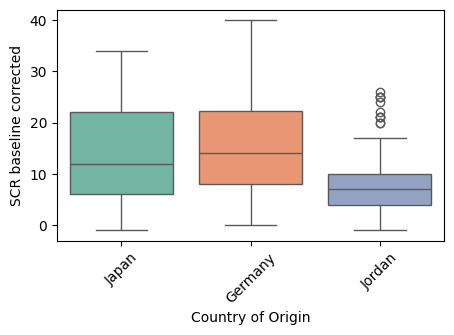

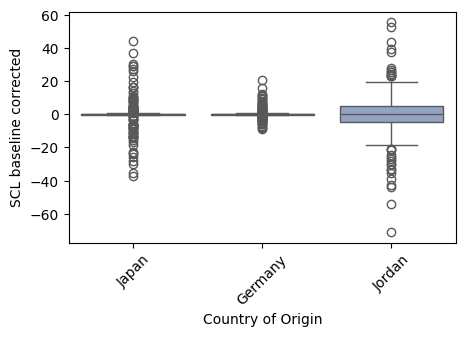

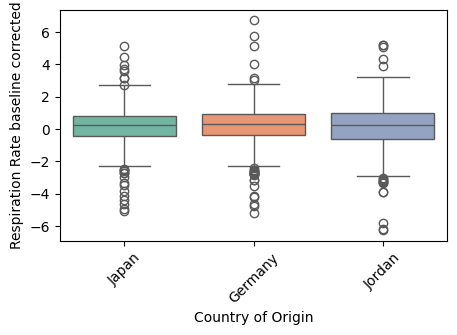

In [7]:
measures = ['scr_minus_baseline', 'scl_minus_baseline', 'resp_rate_minus_baseline']

for measure in measures:
    overall_nonparametric_test(data_physio, measure, 'Country')

H3.2 (1+2) Implementation
---

- Correlation between TIPI "openness to experiennce" score and AWE-S scores
- Correlation between TIPI "openness to experiennce" score and physiological measures (scr, scl, resp_rate)

In [10]:
def format_p_value(p_value):
    return "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"

def correlation_analysis(independent_variable, dataframe, dependent_variables):
    results = []

    for dependent_variable in dependent_variables:
        df_valid = dataframe[[independent_variable.name, dependent_variable]].dropna()

        if df_valid.empty:
            results.append({
                "dependent_variable": dependent_variable,
                "n": 0,
                "correlation": None,
                "p_value": None,
                "method": None,
                "note": "No valid data"
            })
            continue

        # Normality tests
        sw_p_indep = shapiro(df_valid[independent_variable.name])[1]
        sw_p_dep = shapiro(df_valid[dependent_variable])[1]
        ksl_p_indep = lilliefors(df_valid[independent_variable.name])[1]
        ksl_p_dep = lilliefors(df_valid[dependent_variable])[1]

        # Choose correlation method
        if sw_p_indep > 0.05 and sw_p_dep > 0.05:
            method = 'Pearson'
            corr, pval = pearsonr(df_valid[independent_variable.name], df_valid[dependent_variable])
        else:
            method = 'Spearman'
            corr, pval = spearmanr(df_valid[independent_variable.name], df_valid[dependent_variable])

        results.append({
            "dependent_variable": dependent_variable,
            "n": len(df_valid),
            "correlation": corr,
            "p_value": pval,
            "method": method,
            "shapiro_p_indep": sw_p_indep,
            "shapiro_p_dep": sw_p_dep,
            "ksl_p_indep": ksl_p_indep,
            "ksl_p_dep": ksl_p_dep
        })

    return results

def report_correlation_results(results, independent_variable):
    for res in results:
        label = res["dependent_variable"]
        n = res["n"]

        if n == 0:
            print(f"\nSkipping {label} due to lack of valid data.")
            continue

        print("\nNormality tests:")
        print(f"  Shapiro Wilk ({label}): W = --, p = {res['shapiro_p_dep']:.3f}")
        print(f"  Shapiro Wilk ({independent_variable.name}): W = --, p = {res['shapiro_p_indep']:.3f}")
        print(f"  Kolmogorov-Smirnov (Lilliefors) ({label}): D = --, p = {res['ksl_p_dep']:.3f}")
        print(f"  Kolmogorov-Smirnov (Lilliefors) ({independent_variable.name}): D = --, p = {res['ksl_p_indep']:.3f}")
        print(f"  N: {n}")
        print(f"{label} vs {independent_variable.name}")
        print(f"  Correlation method: {res['method']}")
        print(f"\033[1m r({n-2}) = {res['correlation']:.3f}, {format_p_value(res['p_value']*bonferroniCorrection)} \033[0m")


Normality tests:
  Shapiro Wilk (AWE-S_Mean): W = --, p = 0.862
  Shapiro Wilk (TIPI_Openness_to_Experiences): W = --, p = 0.019
  Kolmogorov-Smirnov (Lilliefors) (AWE-S_Mean): D = --, p = 0.766
  Kolmogorov-Smirnov (Lilliefors) (TIPI_Openness_to_Experiences): D = --, p = 0.048
  N: 62
AWE-S_Mean vs TIPI_Openness_to_Experiences
  Correlation method: Spearman
 r(60) = -0.079, p = 11.421 

Normality tests:
  Shapiro Wilk (scr_minus_baseline): W = --, p = 0.000
  Shapiro Wilk (TIPI_Openness_to_Experiences): W = --, p = 0.000
  Kolmogorov-Smirnov (Lilliefors) (scr_minus_baseline): D = --, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (TIPI_Openness_to_Experiences): D = --, p = 0.001
  N: 606
scr_minus_baseline vs TIPI_Openness_to_Experiences
  Correlation method: Spearman
 r(604) = -0.240, p < 0.001 

Normality tests:
  Shapiro Wilk (scl_minus_baseline): W = --, p = 0.000
  Shapiro Wilk (TIPI_Openness_to_Experiences): W = --, p = 0.000
  Kolmogorov-Smirnov (Lilliefors) (scl_minus_baseline):

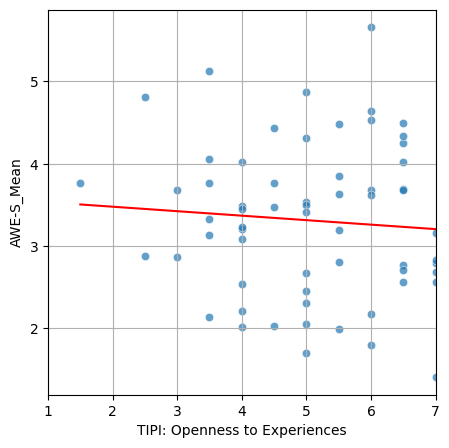

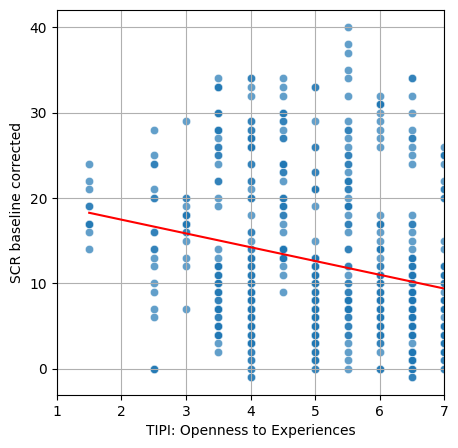

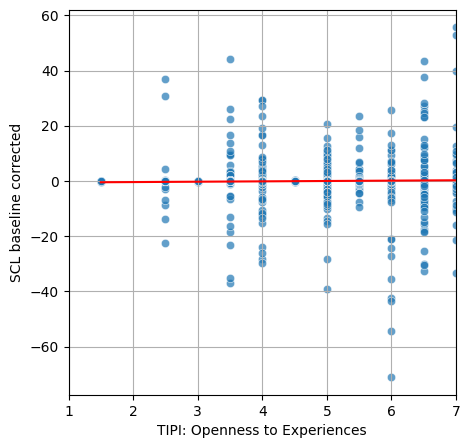

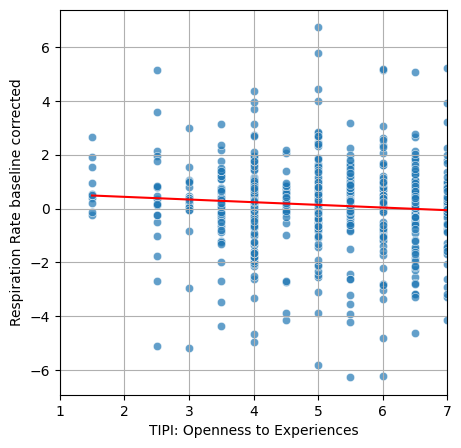

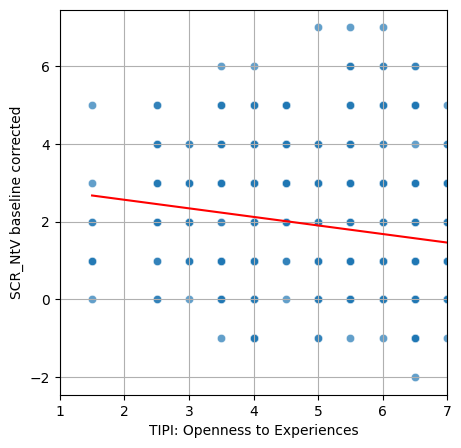

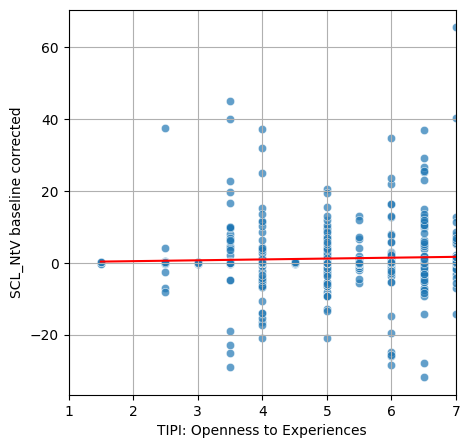

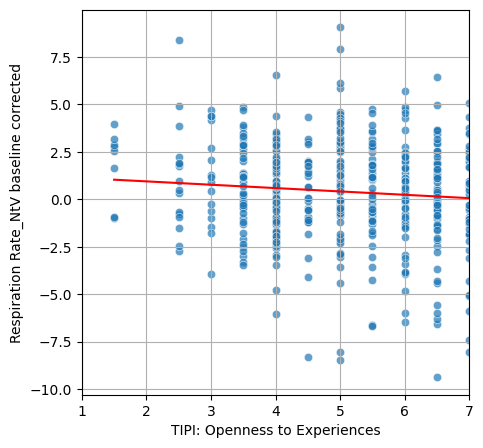

In [11]:
tipi5_awe_correlation_results = correlation_analysis(
    data_questionnaire["TIPI_Openness_to_Experiences"],
    data_questionnaire,
    ['AWE-S_Mean']
)

tipi5_physio_correlation_results = correlation_analysis(
    data_physio["TIPI_Openness_to_Experiences"],
    data_physio,
    [m[0] for m in tipi_physio_metrics]
)

report_correlation_results(tipi5_awe_correlation_results, data_questionnaire["TIPI_Openness_to_Experiences"])
report_correlation_results(tipi5_physio_correlation_results, data_physio["TIPI_Openness_to_Experiences"])